# High Winds - AIFS
---

Winter storm has a tremendous impact on Sweden during the first week of January. A low-pressure system named Floriane impacted various parts of north-western Europe. (France - wind, UK - heavy rain and snow, Denmark - wind, Norway - snow, Sweden - wind and snow)

This example shows analysis of the selected parameters:
- [`z`](https://codes.ecmwf.int/grib/param-db/129) geopotential at constant pressure level 500 hPa,
- [`t`](https://codes.ecmwf.int/grib/param-db/130) temperature at 850 hPa,
- [`msl`](https://codes.ecmwf.int/grib/param-db/151) mean sea level pressure, and
- [`tp`](https://codes.ecmwf.int/grib/param-db/228228) total precipitation of the **AIFS** datasets on 7 January 2025 in Sweden (58.58° N, 11.07° E).

:::{note}
[Geopotential height](https://codes.ecmwf.int/grib/param-db/156) will be calculated from geopotential, because this parameter is not part of the AIFS products.
:::

## 1. Set Up Your Environment and Find ECMWF Open Data
Open data will be downloaded from a publicly available [Amazon S3 Bucket](../datadownload/find-data.ipynb). First, the following Python libraries need to be installed in the current Jupyter kernel:
- `ecmwf-opendata` to download data and
- `earthkit` to analyse and plot the data.

:::{seealso}
More detailed information about how to install Python packages is available on the [Retrieve Data](../datadownload/data-download.ipynb) website.
:::
If the packages are not installed yet, uncomment the code below and run it.

In [ ]:
# !pip3 install earthkit ecmwf-opendata

In [50]:
from ecmwf.opendata import Client
import earthkit.data as ekd
import earthkit.plots as ekp
import earthkit

(content:references:listParam)=
### List of parameters to retrieve from open datasets
The selected values below can be modified.
- Parameters available on pressure levels:

In [56]:
PARAM_PL = "z" # "t"
LEVELS = [500, 850]
LEVELTYPE = "pl"

DATES = [20250104, 20250105, 20250106, 20250107, 20250108]
TIME = 0
STEPS = 0
STREAM = "oper"
TYPE = "fc"
MODEL = "aifs"

:::{important}
Ensure you specify the model correctly! <br>
Before March 2025, the file-naming convention was different. For more information, visit the [Amazon S3 Buckets](../datadownload/source-aws.ipynb) website.
:::

- Parameters available on a single level:

In [ ]:
PARAM_SFC = ["msl", "tp"]
LEVELTYPE = "sfc"

DATES = [20250104, 20250105, 20250106, 20250107, 20250108]
TIME = 0
STEPS = 0
STREAM = "oper"
TYPE = "fc"
MODEL = "aifs"

### Get the data using the ECMWF Open Data API

In [51]:
def get_open_data(date, time, step, stream, _type, model, param, leveltype, levelist=[]):
    client = Client(source="aws")
    list_of_files = []
    # Get the data for all dates
    for _date in DATES:
        filename = f"{model}_{''.join(param)}_{''.join(map(str, levelist))}_{_date}.grib2" if levelist else f"{model}_{''.join(param)}_{leveltype}_{_date}.grib2"
        data = client.retrieve(
            date=_date,
            time=time,
            step=step,
            stream=stream,
            type=_type,
            levtype=leveltype,
            levelist=levelist,
            param=param,
            model=model,
            target=filename
            )
        list_of_files.append(filename)
    return data, list_of_files

## 2. Temperature at 850 hPa

:::{tip}
On the [Heat Waves - AIFS](./heat-waves-aifs.ipynb) website, you can learn more about the analysis of T850 and z500.
:::

In [52]:
data, list_of_files = get_open_data(date=DATES,
                                    time=TIME,
                                    step=STEPS,
                                    stream=STREAM,
                                    _type=TYPE,
                                    model=MODEL,
                                    param=PARAM_PL,
                                    leveltype=LEVELTYPE,
                                    levelist=LEVELS)

:::{seealso}
When we want to alter the values of a GRIB file, then we can store the result in a new array fieldlist straight from metadata and these modified values. More detailed information about building an array fieldlist in a loop, can be found [here](https://earthkit-data.readthedocs.io/en/latest/examples/grib_array_backends.html).
:::

In [53]:
# Select AIFS model data from 4 to 8 January 2025
t = ekd.SimpleFieldList()
for _file in list_of_files:
    ds = ekd.from_source("file", _file)
    md = ds.metadata()
    v = ds.to_array()
    for f in range(len(md)):
        t.append(ekd.ArrayField(v[f], md[f]))
t.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,t,isobaricInhPa,500,20250104,0,0,fc,None,regular_ll
1,ecmf,t,isobaricInhPa,850,20250104,0,0,fc,None,regular_ll
2,ecmf,t,isobaricInhPa,500,20250105,0,0,fc,None,regular_ll
3,ecmf,t,isobaricInhPa,850,20250105,0,0,fc,None,regular_ll
4,ecmf,t,isobaricInhPa,500,20250106,0,0,fc,None,regular_ll
5,ecmf,t,isobaricInhPa,850,20250106,0,0,fc,None,regular_ll
6,ecmf,t,isobaricInhPa,500,20250107,0,0,fc,None,regular_ll
7,ecmf,t,isobaricInhPa,850,20250107,0,0,fc,None,regular_ll
8,ecmf,t,isobaricInhPa,500,20250108,0,0,fc,None,regular_ll
9,ecmf,t,isobaricInhPa,850,20250108,0,0,fc,None,regular_ll


In [54]:
t850 = t.sel({"level": 850, "shortName": "t"})
t850.head()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,t,isobaricInhPa,850,20250104,0,0,fc,None,regular_ll
1,ecmf,t,isobaricInhPa,850,20250105,0,0,fc,None,regular_ll
2,ecmf,t,isobaricInhPa,850,20250106,0,0,fc,None,regular_ll
3,ecmf,t,isobaricInhPa,850,20250107,0,0,fc,None,regular_ll
4,ecmf,t,isobaricInhPa,850,20250108,0,0,fc,None,regular_ll


## 3. Geopotential at 500 hPa
The input values can be set [here](#content:references:listParam).

In [57]:
data, list_of_files = get_open_data(date=DATES,
                                    time=TIME,
                                    step=STEPS,
                                    stream=STREAM,
                                    _type=TYPE,
                                    model=MODEL,
                                    param=PARAM_PL,
                                    leveltype=LEVELTYPE,
                                    levelist=LEVELS)

Geopotential height is calculated by dividing the geopotential by the Earth's mean gravitational acceleration, g (=9.80665 m s-2). In the ECMWF Open Charts, it is plotted in geopotential decameters. Therefore, our result also need to be divided by 10.

In [58]:
# Select AIFS model data from 4 to 8 January 2025
z = ekd.SimpleFieldList()
for _file in list_of_files:
    ds = ekd.from_source("file", _file)
    md = ds.metadata()
    v = ds.to_array() / (9.80665 * 10)
    for f in range(len(md)):
        z.append(ekd.ArrayField(v[f], md[f].override(shortName="gh")))
z.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,gh,isobaricInhPa,850,20250104,0,0,fc,None,regular_ll
1,ecmf,gh,isobaricInhPa,500,20250104,0,0,fc,None,regular_ll
2,ecmf,gh,isobaricInhPa,500,20250105,0,0,fc,None,regular_ll
3,ecmf,gh,isobaricInhPa,850,20250105,0,0,fc,None,regular_ll
4,ecmf,gh,isobaricInhPa,850,20250106,0,0,fc,None,regular_ll
5,ecmf,gh,isobaricInhPa,500,20250106,0,0,fc,None,regular_ll
6,ecmf,gh,isobaricInhPa,500,20250107,0,0,fc,None,regular_ll
7,ecmf,gh,isobaricInhPa,850,20250107,0,0,fc,None,regular_ll
8,ecmf,gh,isobaricInhPa,850,20250108,0,0,fc,None,regular_ll
9,ecmf,gh,isobaricInhPa,500,20250108,0,0,fc,None,regular_ll


In [62]:
gh500 = z.sel({"level": 500, "shortName": "gh"})
gh500.describe("gh")

shortName,gh
typeOfLevel,isobaricInhPa
level,500
date,"20250104,20250105,20250106,20250107,20250108"
time,0
step,0
number,None
paramId,156
class,ai
stream,oper
type,fc


## 3. Data visualisation

The plot below shows analysis of T850 and z500 from 4 to 8 January 2025.

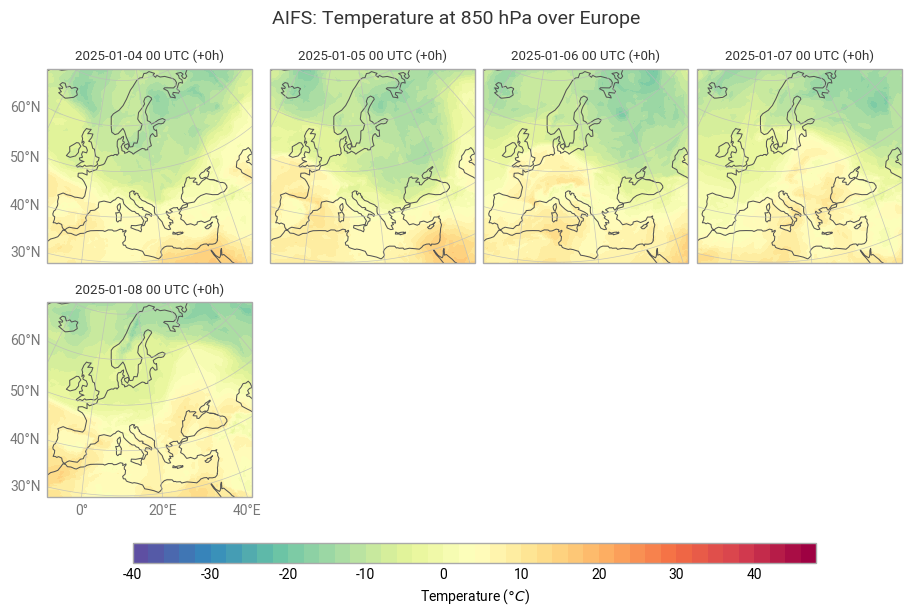

In [71]:
figure = ekp.Figure(domain="Europe", size=(9, 8), rows=3, columns=4)

t850_shade = ekp.styles.Style(
    colors="Spectral_r",
    levels=range(-40, 50, 2),
    units="celsius",
)

for i in range(5):
    figure.add_map(1+i//4, i%4)
figure.contourf(t850, style=t850_shade)

figure.coastlines(resolution="low")
figure.gridlines()

figure.legend(location="bottom", label="{variable_name} ({units})")

figure.subplot_titles("{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)")
figure.title(
    "AIFS: Temperature at 850 hPa over {domain}\n",
    fontsize=14, horizontalalignment="center",
)
figure.save(fname=f"./plots/{PARAM_PL}_{MODEL}_{DATES[-1]}{TIME}-{STEPS}h.png")
figure.show()

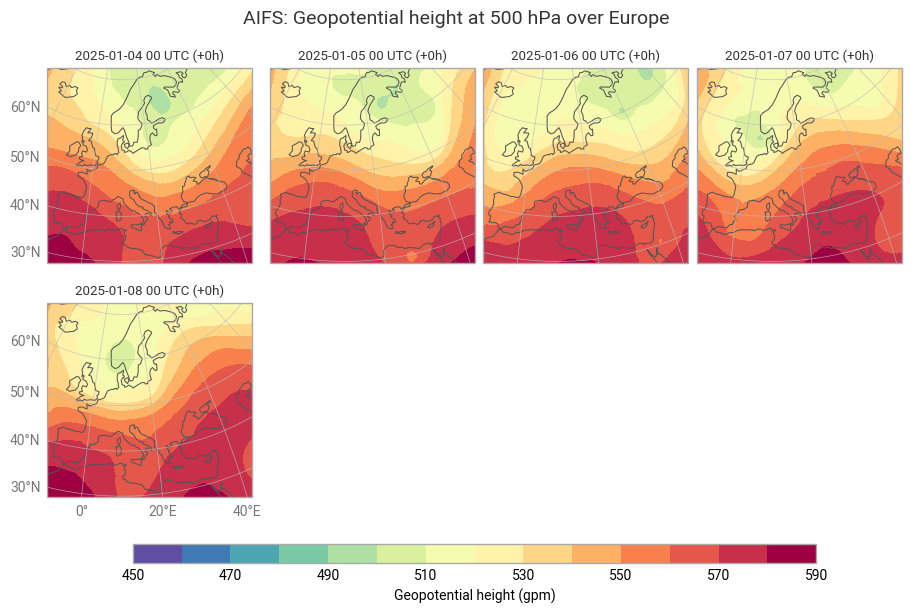

In [78]:
figure = ekp.Figure(domain="Europe", size=(9, 8), rows=3, columns=4)

gh500_shade = ekp.styles.Style(
    colors="Spectral_r",
    levels=range(450, 600, 10),
)

for i in range(5):
    figure.add_map(1+i//4, i%4)
figure.contourf(gh500, style=gh500_shade)

figure.coastlines(resolution="low")
figure.gridlines()

figure.legend(location="bottom", label="{variable_name} ({units})")

figure.subplot_titles("{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)")
figure.title(
    "AIFS: Geopotential height at 500 hPa over {domain}\n",
    fontsize=14, horizontalalignment="center",
)
figure.save(fname=f"./plots/{PARAM_PL}_{MODEL}_{DATES[-1]}{TIME}-{STEPS}h.png")
figure.show()

_To be continued_